In [6]:
import numpy
import larcv
import h5py

from matplotlib import pyplot as plt

In [7]:
data_files = {
  7470 : "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7470_larcv_embedded.h5",
  7471 : "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7471_larcv_embedded.h5",
  7472 : "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7472_larcv_embedded.h5",
  7473 : "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7473_larcv_embedded.h5",
}
energies = {}
events = {}

In [8]:
def read_event_energies(fname):
    print(fname)
    io = larcv.IOManager()
    io.add_in_file(fname)
    io.initialize()
    energies = []
    events   = []
    for i in range(io.get_n_entries()):
        io.read_entry(i)
        hits = io.get_data("sparse3d", "voxels")
        tensor = hits.at(0)
        e1 = tensor.values().sum()
        energies.append(e1)
        events.append(io.event_id().event())
    io.finalize()

    return numpy.asarray(energies), numpy.asarray(events)

In [9]:
for r in data_files.keys():
    en, ev = read_event_energies(data_files[r])
    energies[r] = en
    events[r] = ev

/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7470_larcv_embedded.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7470_larcv_embedded.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7470_larcv_embedded.h5" has 33181 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 33181 entries...
/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7471_larcv_embedded.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7471_larcv_embedded.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7471_larcv_embedded.h5" has 31962 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 31962 entries...
/data/datasets/NEXT/dnn-dataset/data/outdated_larcv/7472_larcv_embedded.h5
    [NORMAL]  <IOManager::prepare_input> Opening 

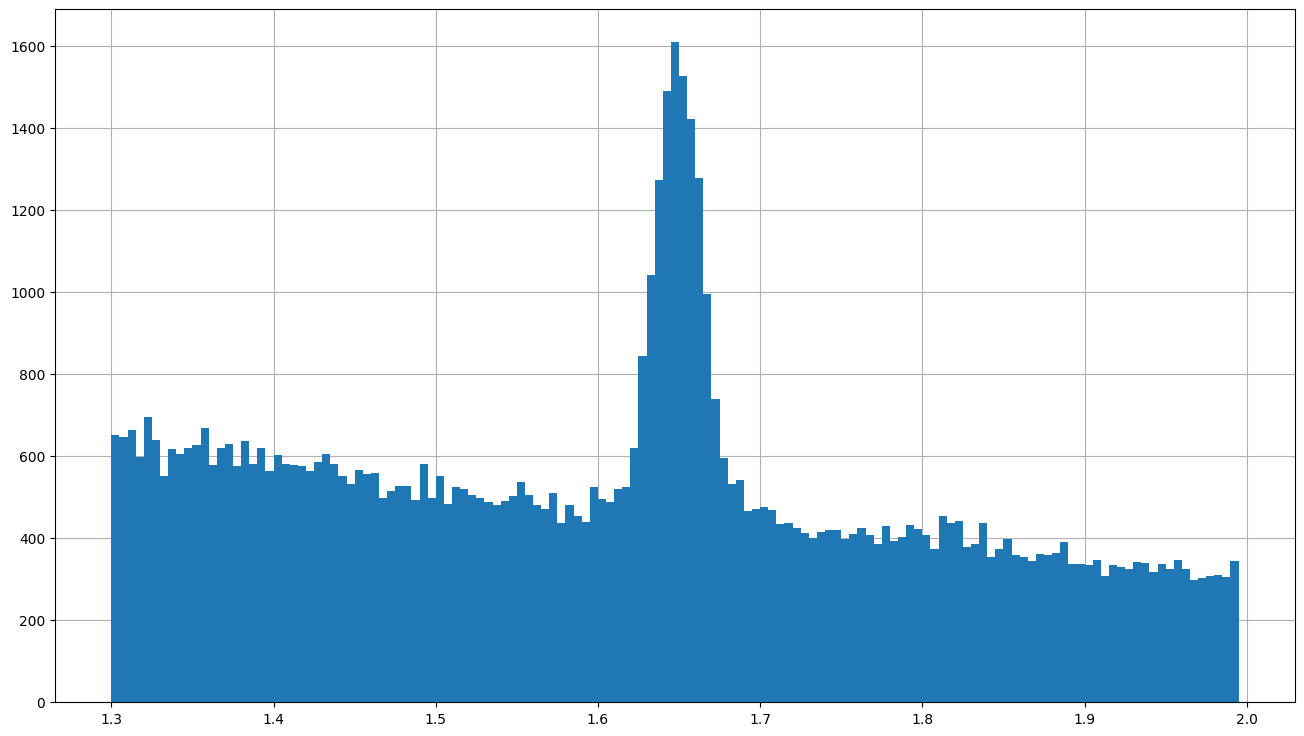

In [10]:
bins = numpy.arange(1.3, 2.0, 0.005)

fig = plt.figure(figsize=(16,9))

total_hist = numpy.zeros_like(bins[1:])

for r in energies.keys():
    hist, edges = numpy.histogram(energies[r], bins=bins)

    bin_centers = 0.5*(edges[1:] + edges[:-1])
    bin_widths  = edges[1:] - edges[:-1]

    total_hist += hist

plt.bar(bin_centers, total_hist, width=bin_widths, zorder=3, label="Data")


plt.grid(True)


In [11]:
from scipy.optimize import curve_fit
import numpy as np
import numpy

def gauss(x, amp, mu, sigma):
    return amp/((sigma * 2*numpy.pi)**.5) * numpy.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * numpy.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * numpy.exp(x/tau) + amp/(2*numpy.pi)**.5/sigma * numpy.exp(-0.5*(x-mu)**2./sigma**2.)

def get_errors(cov):
    """
    Find errors from covariance matrix
    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.
    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return numpy.sqrt(numpy.diag(cov))

def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    if fit_range is not None:
        sel = (fit_range[0] <= x) & (x < fit_range[1])
        x, y = x[sel], y[sel]
        
    vals, cov = curve_fit(func, x, y, seed, **kwargs)
    
    fitf = lambda x: func(x, *vals)
    
    return fitf, vals, get_errors(cov)

In [12]:
seed = (1e5, -0.45, 200, 1.65, 0.05, )
f = fit(expgauss, bin_centers, total_hist, seed)

print(f)
print(f[1])

(<function fit.<locals>.<lambda> at 0x79893206cdc0>, array([ 2.39508689e+03, -9.93936348e-01, -4.15425718e+01,  1.64962328e+00,
       -1.44456478e-02]), array([9.74359576e+01, 2.55539789e-02, 5.73044606e-01, 2.15988278e-04,
       2.20734183e-04]))
[ 2.39508689e+03 -9.93936348e-01 -4.15425718e+01  1.64962328e+00
 -1.44456478e-02]


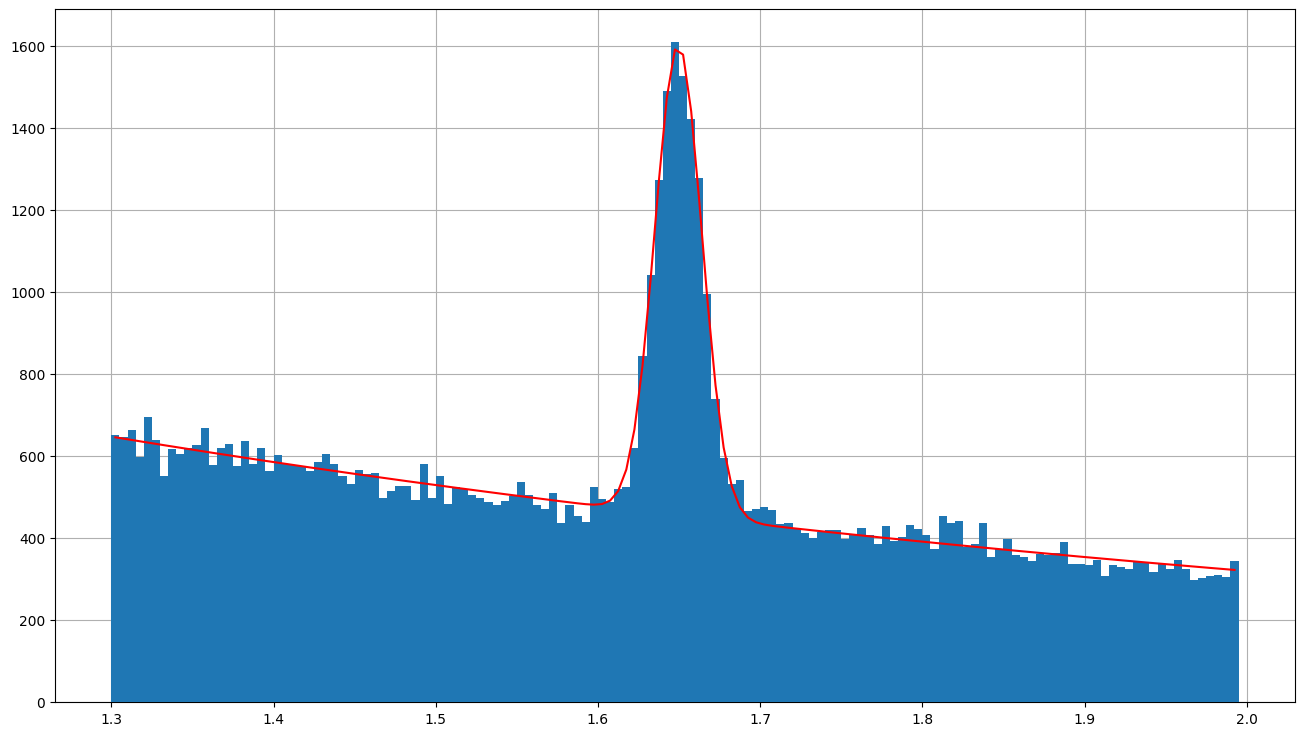

In [13]:
fig = plt.figure(figsize=(16,9))
plt.bar(bin_centers, total_hist, width=bin_widths, zorder=3, label="Data")


plt.plot(bin_centers, f[0](bin_centers), color="red", zorder=4)

plt.grid(True)

In [14]:
new_cdst = "/home/cadams/NEXT/next-sample-generation/tl208_sim.h5_cuts.h5"

def read_event_energies(fname):
    print(fname)
    io = larcv.IOManager()
    io.add_in_file(fname)
    io.initialize()
    energies = []
    events   = []
    for i in range(io.get_n_entries()):
        io.read_entry(i)
        hits = io.get_data("sparse3d", "chitslowTh")
        tensor = hits.at(0)
        e1 = tensor.values().sum()
        energies.append(e1)
        events.append(io.event_id().event())
    io.finalize()

    return numpy.asarray(energies), numpy.asarray(events)

In [15]:
en, ev = read_event_energies(new_cdst)

/home/cadams/NEXT/next-sample-generation/tl208_sim.h5_cuts.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/home/cadams/NEXT/next-sample-generation/tl208_sim.h5_cuts.h5"
    [NORMAL]  <IOManager::prepare_input> File "/home/cadams/NEXT/next-sample-generation/tl208_sim.h5_cuts.h5" has 220 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 220 entries...


In [16]:
en.mean()

1.6035718

In [17]:
f = h5py.File(new_cdst)["Data"]['particle_event_group']['particles']["energy_deposit"]
print(f)

[1.49118266 1.49915552 1.68933218 1.44503081 1.51162217 1.60944358
 1.54735405 1.60764567 1.52679008 1.60411942 1.73506805 1.80484116
 1.50543999 1.51104172 1.58406878 1.60347355 1.60496135 1.66334643
 1.59515336 1.61016957 1.59515299 1.44322929 1.42279086 1.69452308
 1.64575328 1.60064067 1.59843293 1.50735246 1.71601509 1.568085
 1.59859342 1.62484635 1.76612889 1.7027149  1.70582471 1.60233813
 1.4446793  1.46832652 1.59973766 1.61738236 1.56633352 1.61371835
 1.60869513 1.56928576 1.60185445 1.57517231 1.60865193 1.56159938
 1.74563508 1.46416988 1.59893096 1.80915454 1.60423696 1.41724505
 1.58189978 1.69837986 1.60129503 1.61383213 1.60993894 1.58228375
 1.77501488 1.43690905 1.60052504 1.6006357  1.70612981 1.48533025
 1.69706751 1.48506528 1.45390208 1.73731334 1.70710047 1.56490111
 1.73899784 1.59475723 1.43782113 1.60434466 1.72759799 1.80491587
 1.48441438 1.52593661 1.49513769 1.77058527 1.6089252  1.58068471
 1.59840746 1.72315178 1.60054816 1.51126388 1.64586446 1.564852

In [18]:
(en -f ).max()

0.033717966227025054

In [19]:
numpy.isnan(f).any()

False

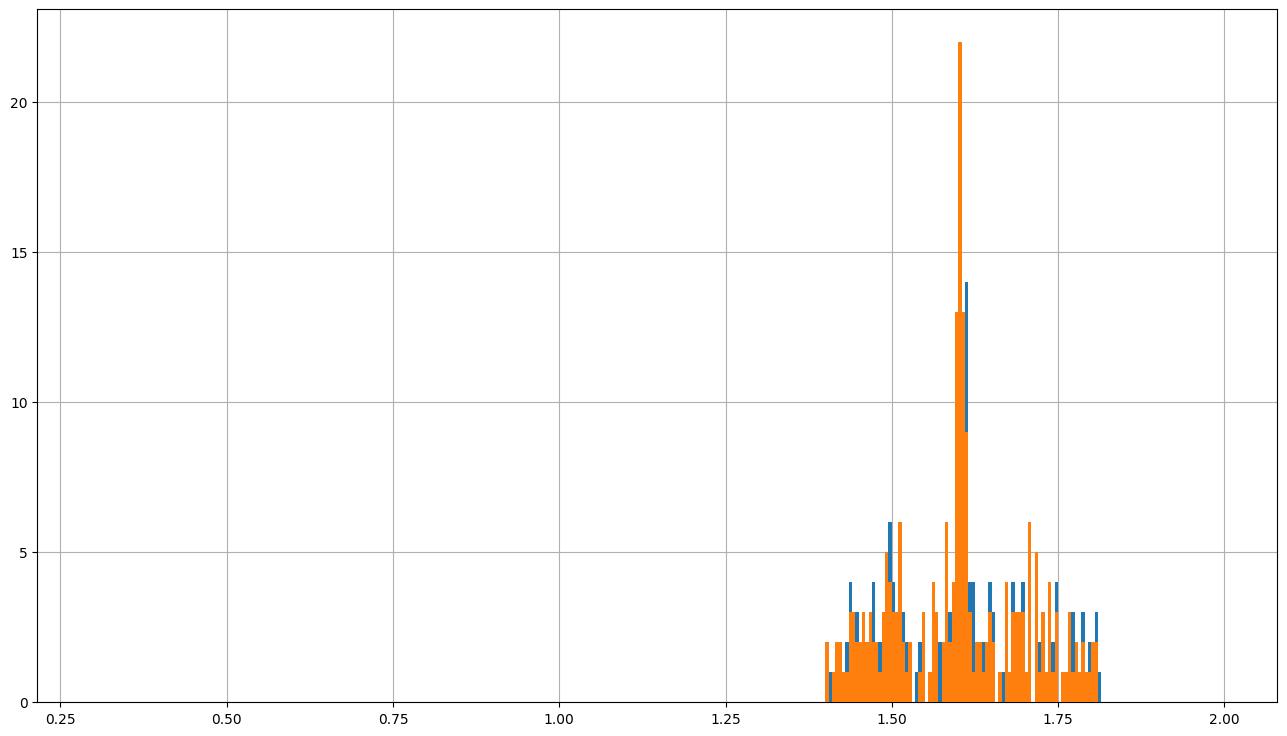

In [21]:
bins = numpy.arange(0.3, 2.0, 0.005)

fig = plt.figure(figsize=(16,9))

total_hist = numpy.zeros_like(bins[1:])

hist, edges = numpy.histogram(en, bins=bins)
hist_f, edges = numpy.histogram(f, bins=bins)

bin_centers = 0.5*(edges[1:] + edges[:-1])
bin_widths  = edges[1:] - edges[:-1]


plt.bar(bin_centers, hist, width=bin_widths, zorder=3, label="Data")
plt.bar(bin_centers, hist_f, width=bin_widths, zorder=3, label="Data")


plt.grid(True)
